In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from scipy.ndimage import convolve1d
import utils
import torch
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot




In [21]:
cols = ["fix_acidity", "vol_acidity", "critic_acidity", "res_sugar", "chloride", "free_SO2", "tot_SO2", "density", "pH","sulphate", "alcohol", "class"] # Quality is class

df = pd.read_csv("winequality-red.csv", names = cols, delimiter=";", header=0)


In [22]:
#change data type to value
data = df.values

In [23]:
#separating the X, y. They are the class and atributes and should be separated for the rest of the calculations.
X, y = data[:, :-1], data[:, -1]

In [24]:
#we do necessary changes for the oversampling method SMOTE, since data is imbalanced.
y = LabelEncoder().fit_transform(y)

In [25]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [26]:
counter = Counter(y)


Class=2, n=681 (16.667%)
Class=3, n=681 (16.667%)
Class=4, n=681 (16.667%)
Class=1, n=681 (16.667%)
Class=5, n=681 (16.667%)
Class=0, n=681 (16.667%)


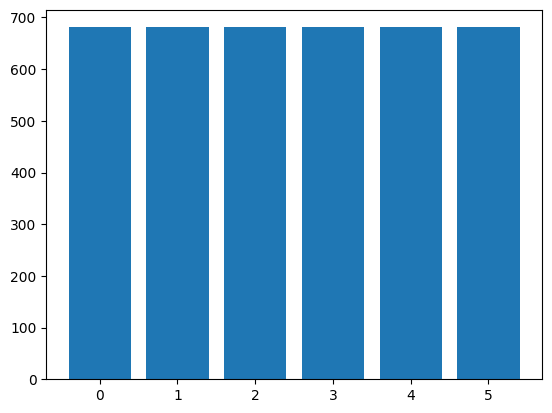

In [27]:
#the data becomes balanced, we just have the class from 3 to 8 available data.
#This data is shown by 0 to 5 (6 classes) in the x-axis, y-axis number of instances

for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [28]:
y.shape

(4086,)

In [29]:
X

array([[ 7.4       ,  0.7       ,  0.        , ...,  3.51      ,
         0.56      ,  9.4       ],
       [ 7.8       ,  0.88      ,  0.        , ...,  3.2       ,
         0.68      ,  9.8       ],
       [ 7.8       ,  0.76      ,  0.04      , ...,  3.26      ,
         0.65      ,  9.8       ],
       ...,
       [ 7.90681933,  0.37543839,  0.36029226, ...,  3.29058451,
         0.89300291, 10.85828062],
       [11.14305142,  0.54937314,  0.63337867, ...,  3.20168933,
         0.67953676, 12.7722057 ],
       [ 9.87777703,  0.33617522,  0.50012814, ...,  3.06846159,
         0.75717947, 10.63760707]])

In [30]:
y

array([2, 2, 2, ..., 5, 5, 5])

In [31]:
#separate the train and test set
#not usable for the current method


#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)



In [32]:
#we start the neural network method
#encode to numpy array


from keras.utils import np_utils


encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(encoded_Y)

[2 2 2 ... 5 5 5]


In [33]:
#optimizer can be Adam 
#loss function should be categorical_crossentropy
#EarlyStopping callbacks to prevent overfitting

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [34]:
print(dummy_y)


[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [35]:
#Neural network model contain two layers of 10 and 6 neurons
#

model = Sequential()
model.add(Dense(100, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(50, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(20, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(12, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 12)                252       
                                                                 
 dense_4 (Dense)             (None, 6)                 78        
                                                                 
Total params: 7,600
Trainable params: 7,600
Non-trainable params: 0
_________________________________________________________________


2022-11-14 17:56:44.652361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 17:56:44.653469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
#imply learning

import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=800000, # you can set this to a big number!
                    batch_size=10,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/800000


2022-11-14 17:57:10.672380: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-14 17:57:10.960064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


327/327 [==============================] - ETA: 0s - loss: 1.6410 - accuracy: 0.3081

2022-11-14 17:57:16.093357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


327/327 [==============================] - 6s 15ms/step - loss: 1.6410 - accuracy: 0.3081 - val_loss: 4.2817 - val_accuracy: 0.1284
Epoch 2/800000
327/327 [==============================] - 4s 13ms/step - loss: 1.4431 - accuracy: 0.3755 - val_loss: 5.3031 - val_accuracy: 0.0782
Epoch 3/800000
327/327 [==============================] - 4s 13ms/step - loss: 1.3059 - accuracy: 0.4397 - val_loss: 4.6991 - val_accuracy: 0.0929
Epoch 4/800000
327/327 [==============================] - 4s 13ms/step - loss: 1.2257 - accuracy: 0.4823 - val_loss: 4.8254 - val_accuracy: 0.1039
Epoch 5/800000
327/327 [==============================] - 4s 13ms/step - loss: 1.1805 - accuracy: 0.4957 - val_loss: 5.1250 - val_accuracy: 0.1186
Epoch 6/800000
327/327 [==============================] - 4s 13ms/step - loss: 1.1329 - accuracy: 0.5248 - val_loss: 5.2797 - val_accuracy: 0.1870
Epoch 7/800000
327/327 [==============================] - 4s 13ms/step - loss: 1.0994 - accuracy: 0.5490 - val_loss: 5.2943 - val_acc

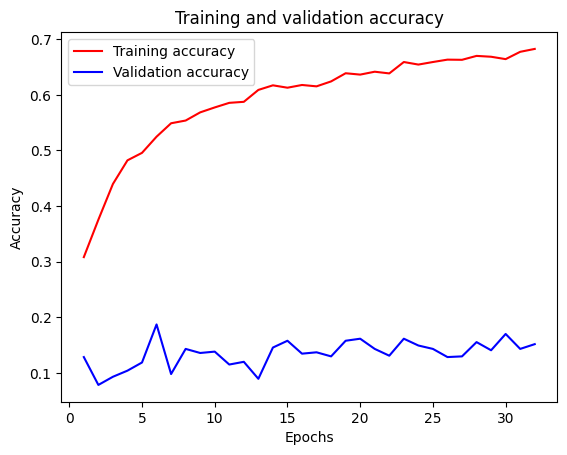

In [37]:
#check the train and test

import matplotlib.pyplot as plt

history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [38]:
#detail info, need to be studied

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(X) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1
## [9.9999988e-01 1.3509347e-07 6.7064638e-16]
## 1.0

# Almost a perfect prediction
# actual is left, predicted is top
# names can be found by inspecting Y
matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
matrix
## array([[50,  0,  0],
##        [ 0, 46,  4],
##        [ 0,  1, 49]])


# more detail on how well things were predicted
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))

  1/128 [..............................] - ETA: 28s

2022-11-14 17:59:47.124011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 0s 2ms/step
[9.3639158e-02 4.0526170e-01 3.9849228e-01 1.0171038e-01 8.9655753e-04
 6.9192846e-10]
1.0
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       681
           1       0.62      0.62      0.62       681
           2       0.54      0.54      0.54       681
           3       0.34      0.29      0.31       681
           4       0.40      0.66      0.50       681
           5       0.00      0.00      0.00       681

    accuracy                           0.52      4086
   macro avg       0.43      0.52      0.46      4086
weighted avg       0.43      0.52      0.46      4086



/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [94]:
############################################################################
################
#After here, its useless for now!

In [51]:
model = keras.Sequential([

keras.layers.Dense(6, input_dim = 11, activation = 'softmax'),
keras.layers.Dense(3, activation = 'softmax'),
keras.layers.Dense(1, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

model.fit(x_train, y_train, batch_size = 10, epochs = 10)

Epoch 1/10


2022-11-13 18:22:19.654936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


307/307 [==============================] - 3s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 2/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 3/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 4/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 5/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 6/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 7/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 8/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 9/10
307/307 [==============================] - 2s 8ms/step - loss: 0.0000e+00 - accuracy: 0.1697
Epoch 10/10
307/307 [==============================] - 2s 8ms/step - loss: 

In [55]:
model.evaluate(x_test, y_test)

16/32 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1602

2022-11-13 18:24:57.421265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.1575


[0.0, 0.15753424167633057]

In [56]:
y_pred = model.predict(x_test).reshape(-1)
print(y_pred[:10])

y_pred = np.round(y_pred)

32/32 [==============================] - 0s 2ms/step
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


2022-11-13 18:25:05.438780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
